In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
from pprint import pprint
import os
from sklearn import preprocessing
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.flux_table import FluxTable
import datetime
from typing import List, Callable
import itertools
import datetime
from statsmodels.stats.diagnostic import breaks_cusumolsresid
import npd_entropy
from sidpy import *


/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:8: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/s02435/ghq/github.com/nnao45/jaist-my-jupyter/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:8: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
def compute_enet( x_train, y_train, alpha = 1.0, l1_ratio = 0.5) -> ElasticNet:
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(x_train, y_train)

def enet_loop(x, y, alpha = 1.0, l1_ratio = 0.5, batch_size = 300, incr = 30):
    y_pred = pd.DataFrame([])
    counter = batch_size
    while len(x) > counter:
        try:
            x_train = x[counter-batch_size:counter]
            y_train = y[counter-batch_size:counter]
            x_test = x[counter:counter+incr].reshape(-1, 1)
            enet = compute_enet(x_train, y_train, alpha, l1_ratio)
            target_y_pred = enet.predict(x_test)
            y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
            counter += incr
        except Exception as e:
            print(e)
            counter += incr
    return y_pred

In [3]:
def fuzzy_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [nk.entropy_fuzzy(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

In [5]:
# InfluxDBサーバーのIPアドレスとポート
url = "http://localhost:8086"
# 対象organization
org = "nnao45"
# 対象bucket
bucket = "lab"
# 発行したToken
token = "a5MLHcVrgLgeemWgvTnvNwx83ay4at6l9mmEjB8Zm8KxTr5VHYto-qYMyizBQ0tsORqdaxt3LK2xs1IjCnE6vw=="

In [7]:
client = InfluxDBClient(url=url, token=token, org=org)
 
write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()

In [8]:
p = Point("my_measurement").tag("location", "Prague").field("temperature", 25.3)
write_api.write(bucket=bucket, record=p)

In [9]:
query_api.query('from(bucket:"' + bucket + '") |> range(start: -10m)')


[<FluxTable: 9 columns, 1 records>]

In [4]:
def fetch_gatling_records(start_at: datetime.datetime, end_at: datetime.datetime):
    tables: List[FluxTable] = query_api.query((
        'from(bucket: "' + bucket + '")' +
        ' |> range(start: ' + start_at.isoformat() + 'Z, stop: ' + end_at.isoformat() + 'Z)' +
        ' |> filter(fn: (r) => r["_measurement"] == "gatlingLog")' +
        ' |> filter(fn: (r) => r["_field"] == "status")' +
        ' |> truncateTimeColumn(unit: 1s)' +
        ' |> group(columns: ["_time"])' +
        ' |> count()' +
        ' |> yield(name: "counts")'
    ))
    return [[{"timestamp": row.values["_time"], "count": row.values["_value"]} for row in table.records][0] for table in tables]

def fetch_top_records(measurement: str, tag: str, start_at: datetime.datetime, end_at: datetime.datetime):
    tables: List[FluxTable] = query_api.query((
        'cpu =' +
        ' from(bucket: "' + bucket + '")' +
        ' |> range(start: time(v: "' + start_at.isoformat() + 'Z"), stop: time(v: "' + end_at.isoformat() + 'Z"))' +
        ' |> filter(fn: (r) => r["_measurement"] == "' + measurement + '")' +
        ' |> filter(fn: (r) => r["_field"] == "cpu")' +
        ' ' +
        'mem =' +
        ' from(bucket: "' + bucket + '")' +
        ' |> range(start: time(v: "' + start_at.isoformat() + 'Z"), stop: time(v: "' + end_at.isoformat() + 'Z"))' +
        ' |> filter(fn: (r) => r["_measurement"] == "' + measurement + '")' +
        ' |> filter(fn: (r) => r["_field"] == "mem")' +
        ' ' +
        'join(tables: {t1: cpu, t2: mem}, on: ["_time", "' + tag + '"], method: "inner")' +
        ' |> keep(columns: ["_time", "' + tag +'", "_field_t1", "_field_t2", "_value_t1", "_value_t2"])'
        
    ))
    return [[row.values for row in table.records] for table in tables]

In [10]:
gatling_01 = fetch_gatling_records(datetime.datetime(2022, 6, 1), datetime.datetime(2022, 6, 3))

In [15]:
gatling_01_x = np.array([g["timestamp"].timestamp() for g in gatling_01]).reshape(-1, 1)
gatling_01_y = np.array([g["count"] for g in gatling_01]).reshape(-1, 1)

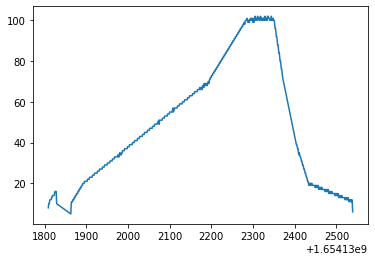

In [16]:
plt.plot(gatling_01_x, gatling_01_y)